In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

In [2]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

In [3]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ Gamma(1.0, 1.0)
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(ms, ws)

    return scheduler, z, A, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [4]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                  priors_ms, priors_ws, 
                                                                  options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(ws), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (m, w)) in enumerate(zip(ms, ws))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [18]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

# γs = [959.2094260579204, 627.2803268468829]
# θs = [[0.8439404913192723, -0.02633221731146529, -0.17013933685100763], [0.32597851804779204, 0.06686167333451845, -0.008763511052602146]]
γs = [80082, 34003]
# θs = [[0.3, 0.1, -0.2], [0.1, -0.2, -0.5]]
θs = [[1.25166, -0.423974], [1.04586, -0.198375]]
ARorder = length(first(θs))

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = 0.1*ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

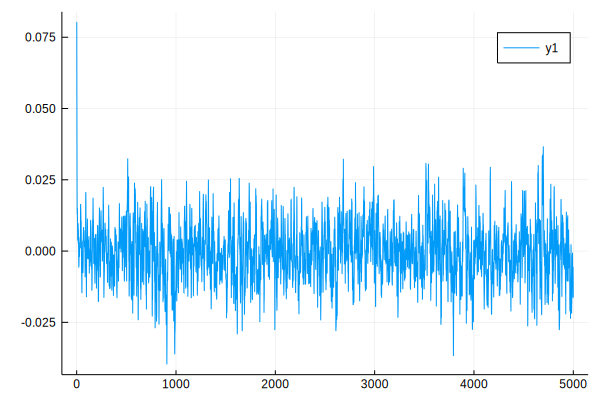

In [19]:
using Plots
plot(outputs)

In [20]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)];

In [21]:
priors_ms = map(θ -> MvGaussianMeanPrecision(θ, 1e4*diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, diageye(ARorder)), θs)

@time mzs, mγs, mθs, mA, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 500, 100, priors_ms, priors_ws);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 24.673274 seconds (133.17 M allocations: 8.615 GiB, 24.11% gc time)


In [22]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.380568  0.00418926
 0.619432  0.995811

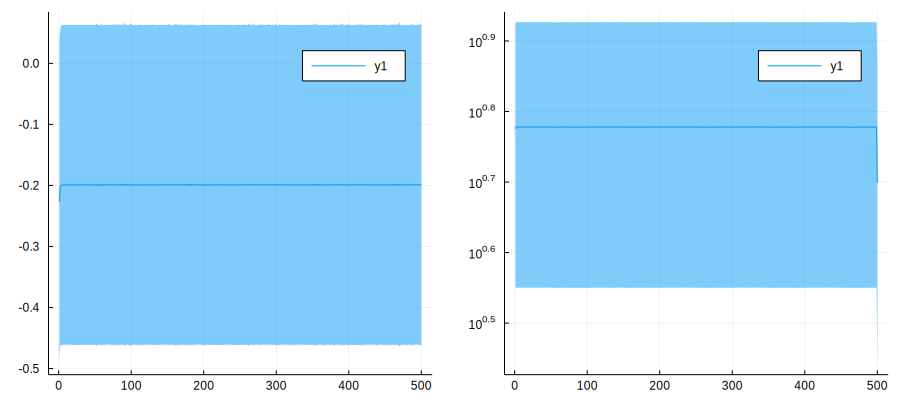

In [24]:
dim(n) = (x) -> map(i -> i[n], x)
index = 2
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

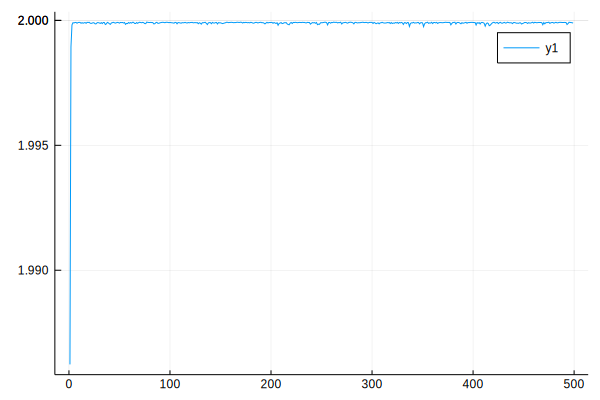

In [94]:
plot(mean.(mzs[end][1:end-1]))